In [1]:
!pip install tensorflow[and-cuda] numpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.2/577.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [1]:
import os
import numpy as np  # Importing numpy for Matrix Operations
import pandas as pd  # Importing pandas to read CSV files
import matplotlib.pyplot as plt # Importting matplotlib for Plotting and visualizing images
import math # Importing math module to perform mathematical operations
import cv2 # Importing openCV for image processing
import seaborn as sns # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

#Sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
images = np.load('/content/drive/My Drive/Colab Notebooks/images_proj.npy')
# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Labels_proj.csv')

### Data Overview



In [5]:
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


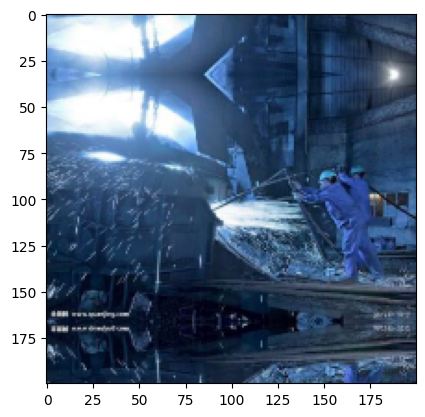

In [6]:
plt.imshow(images[5])

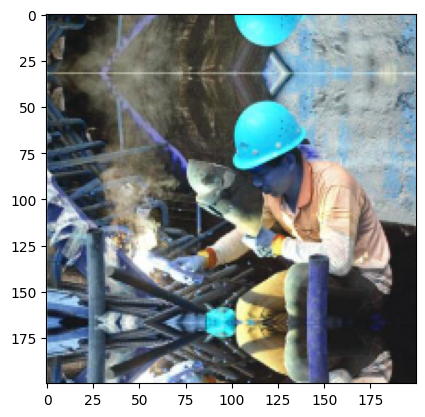

In [7]:
plt.imshow(images[1])

### Exploratory Data Analysis

In [8]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [9]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          # ax.set_title(keys[random_index])
          ax.set_title(labels.iloc[random_index, 0])

  plt.show()

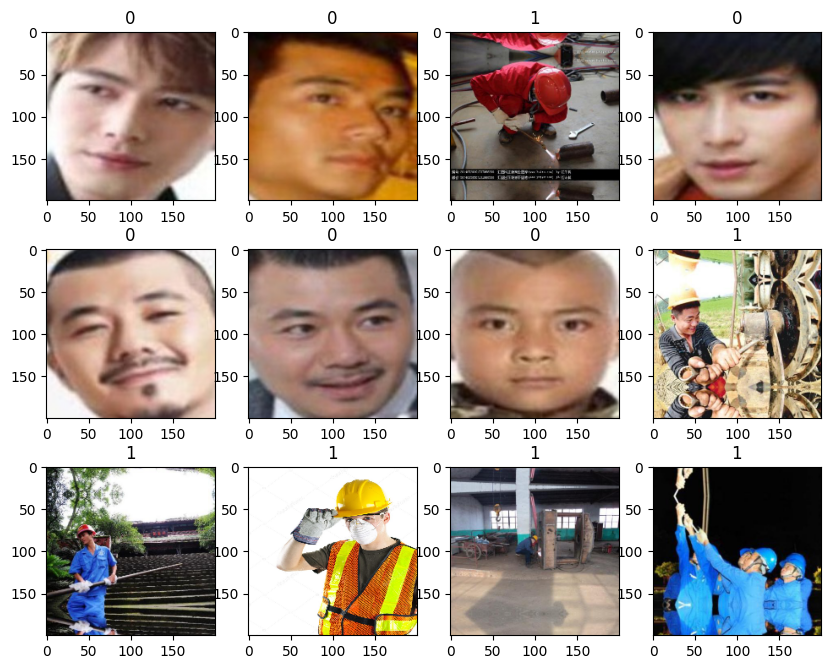

In [10]:
plot_images(images,labels)

### Checking for data imbalance

In [11]:
labels.head()

,Label
0,1
1,1
2,1
3,1
4,1


In [12]:
labels.value_counts()

,count
Label,
0,320
1,311


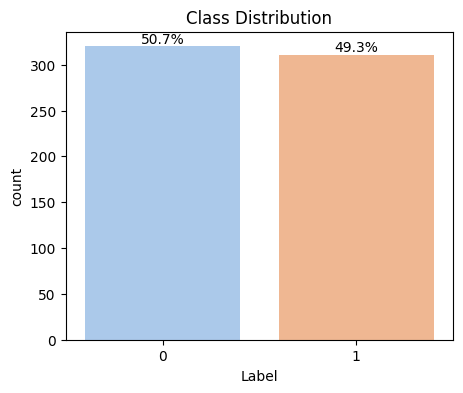

In [13]:
plt.figure(figsize=(5,4))
ax = sns.countplot(x='Label', data=labels, palette="pastel")
total = len(labels)  # total samples
# Add percentages on top
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title("Class Distribution")
plt.show()


Split the data into train, validation, and test

In [14]:
# Splitting the dataset into training (80%) and temporary (20%) sets
# stratify=labels ensures that class distribution is maintained in both sets
X_train_rgb, X_temp_rgb, y_train_rgb, y_temp_rgb = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val_rgb, X_test_rgb, y_val_rgb, y_test_rgb = train_test_split(X_temp_rgb,y_temp_rgb , test_size=0.5, random_state=42,stratify=y_temp_rgb)

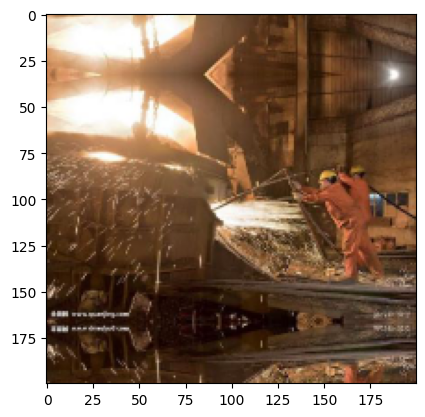

In [15]:
plt.imshow(images[5])

In [16]:
print(X_train_rgb.shape,y_train_rgb.shape)
print(X_val_rgb.shape,y_val_rgb.shape)
print(X_test_rgb.shape,y_test_rgb.shape)


(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


In [17]:
images_decreased = []
height = 128
width = 128
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i],dimensions, interpolation=cv2.INTER_LINEAR))

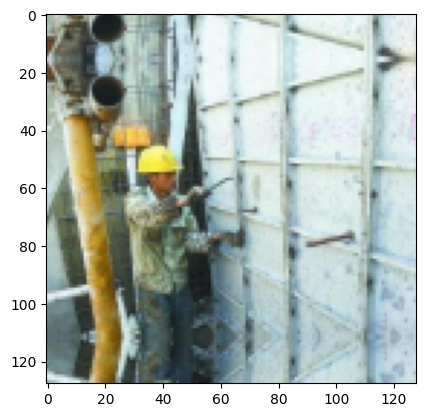

In [18]:
plt.imshow(images_decreased[3]);

#### Apply at least 2 Image Preprocessing techniques on the original/undivided data (e.g, Blur, Grayscale, Filtering, etc.)





In [19]:
def grid_plot(img1,img2,gray=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if gray:
      axes[1].imshow(img2,cmap='gray')
    else:
      axes[1].imshow(img2)
    axes[1].set_title('Processed Image')
    axes[1].axis('off')

    plt.show()

In [20]:
gray_images = []
for i in range(len(images)):
  gray_images.append(cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY))

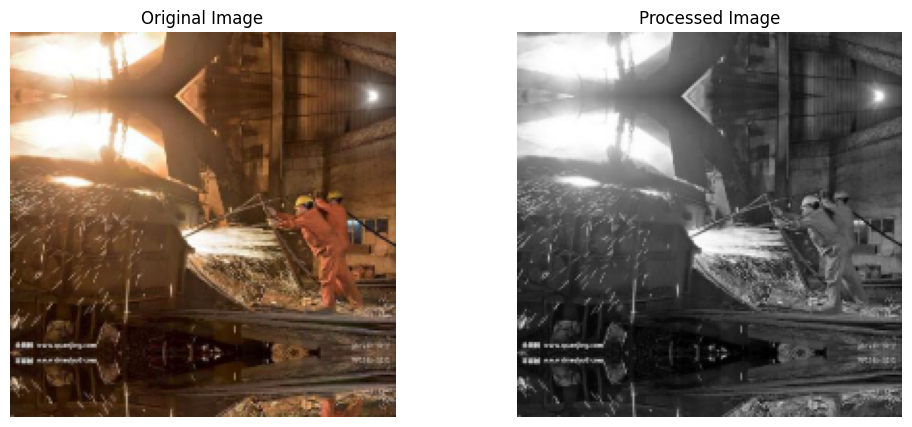

In [21]:
# choosing an image
n = 5
# plotting the original and preprocessed image
grid_plot(images[n],gray_images[n],gray=True)

In [22]:
edge_images = []
for i in range(len(gray_images)):
    edge_images.append(cv2.Laplacian(gray_images[i],cv2.CV_64F))

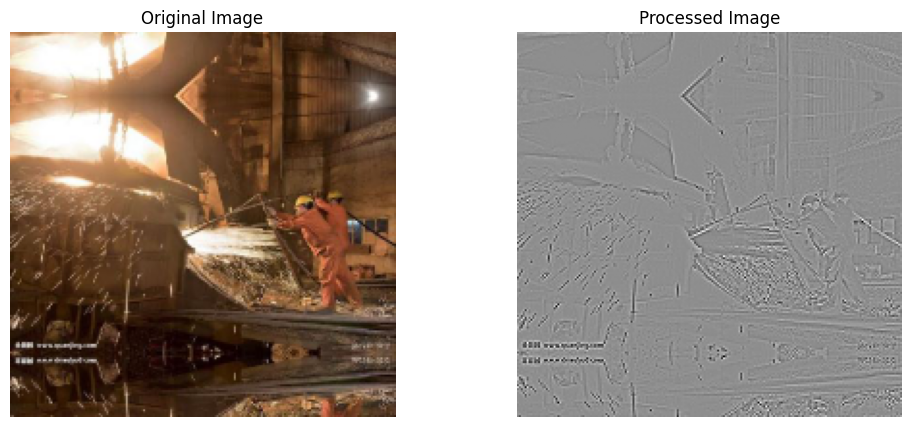

In [23]:
# choosing an image
n = 5
# plotting the original and preprocessed image
grid_plot(images[n],edge_images[n],gray=True)

##### Split the preprocessed data into train, validation, and test

In [24]:
X_train_gray, X_temp_gray, y_train_gray, y_temp_gray = train_test_split(np.array(gray_images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(X_temp_gray,y_temp_gray , test_size=0.5, random_state=42,stratify=y_temp_gray)

In [25]:
print(X_train_gray.shape,y_train_gray.shape)
print(X_val_gray.shape,y_val_gray.shape)
print(X_test_gray.shape,y_test_gray.shape)

(504, 200, 200) (504, 1)
(63, 200, 200) (63, 1)
(64, 200, 200) (64, 1)


In [26]:
X_train_edge, X_temp_edge, y_train_edge, y_temp_edge = train_test_split(np.array(edge_images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val_edge, X_test_edge, y_val_edge, y_test_edge = train_test_split(X_temp_edge,y_temp_edge,test_size=0.5, random_state=42,stratify=y_temp_edge)

If your labels are already 0 and 1 (e.g., (631,1) array of 0s and 1s):  you don’t need LabelBinarizer.

If your labels are text (e.g., “With Helmet”, “Without Helmet”): you should use LabelBinarizer (or LabelEncoder) to convert them into 0/1

In [27]:
# from sklearn.preprocessing import LabelBinarizer
# enc = LabelBinarizer()
# y_train_encoded = enc.fit_transform(y_train_rgb)
# y_val_encoded = enc.transform(y_val_rgb)
# y_test_encoded = enc.transform(y_test_rgb)

In [28]:
# print(y_train_encoded[0])

#### - Apply Normalization to both datasets

In [29]:
# Normalizing the image pixels
X_train_rgb = X_train_rgb.astype('float32')/255.0
X_val_rgb = X_val_rgb.astype('float32')/255.0
X_test_rgb = X_test_rgb.astype('float32')/255.0

In [30]:
X_train_gray = X_train_gray.astype('float32')/255.0
X_val_gray = X_val_gray.astype('float32')/255.0
X_test_gray = X_test_gray.astype('float32')/255.0

In [31]:
# Normalizing the image pixels
X_train_edge = X_train_edge.astype('float32')/255.0
X_val_edge = X_val_edge.astype('float32')/255.0
X_test_edge = X_test_edge.astype('float32')/255.0

### MODEL BUILDING

In [32]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors).argmax(axis=1)

    target = target.argmax(axis=1)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [33]:
  def plot_confusion_matrix(model,predictors,target):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors).argmax(axis=1)

    target = target.argmax(axis=1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

### Simple ANN with Image Flattening

In [34]:
from tensorflow.keras.utils import to_categorical
num_classes = labels['Label'].nunique()
y_train_cat = to_categorical(y_train_rgb, num_classes)
y_val_cat   = to_categorical(y_val_rgb, num_classes)


In [35]:
num_classes = labels['Label'].nunique()
image_size = X_train_rgb[0].size
shape = X_train_rgb.shape[1:]

In [36]:
model_1 = Sequential()
model_1.add(Input(shape=(shape[0],shape[1],shape[2])))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu',kernel_initializer='he_uniform',input_shape=(image_size,)))
model_1.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(num_classes, activation='softmax'))

In [37]:
from tensorflow.keras.losses import binary_crossentropy
adam = optimizers.Adam()
model_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['recall'])

In [38]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 120000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    30,720,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,761,538 (117.35 MB)

 Trainable params: 30,761,538 (117.35 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
train_datagen = ImageDataGenerator()

In [40]:
history_1 = model_1.fit(train_datagen.flow(X_train_rgb,y_train_cat,batch_size=128),validation_data = (X_val_rgb,y_val_cat),epochs=15, verbose=2)

Epoch 1/15
4/4 - 6s - 2s/step - loss: 25.1744 - recall: 0.5040 - val_loss: 3.8437 - val_recall: 0.6667
Epoch 2/15
4/4 - 8s - 2s/step - loss: 3.9133 - recall: 0.6786 - val_loss: 1.8893 - val_recall: 0.7302
Epoch 3/15
4/4 - 6s - 2s/step - loss: 1.6476 - recall: 0.8274 - val_loss: 1.9580 - val_recall: 0.7937
Epoch 4/15
4/4 - 5s - 1s/step - loss: 1.4694 - recall: 0.8274 - val_loss: 1.1881 - val_recall: 0.8095
Epoch 5/15
4/4 - 6s - 2s/step - loss: 1.0393 - recall: 0.8770 - val_loss: 1.3926 - val_recall: 0.7778
Epoch 6/15
4/4 - 3s - 844ms/step - loss: 0.9693 - recall: 0.8869 - val_loss: 0.7527 - val_recall: 0.8571
Epoch 7/15
4/4 - 3s - 840ms/step - loss: 0.7679 - recall: 0.8810 - val_loss: 0.5526 - val_recall: 0.8889
Epoch 8/15
4/4 - 7s - 2s/step - loss: 1.0358 - recall: 0.8333 - val_loss: 0.7659 - val_recall: 0.8254
Epoch 9/15
4/4 - 8s - 2s/step - loss: 2.0461 - recall: 0.7798 - val_loss: 1.1741 - val_recall: 0.8413
Epoch 10/15
4/4 - 7s - 2s/step - loss: 1.9422 - recall: 0.7877 - val_loss: 

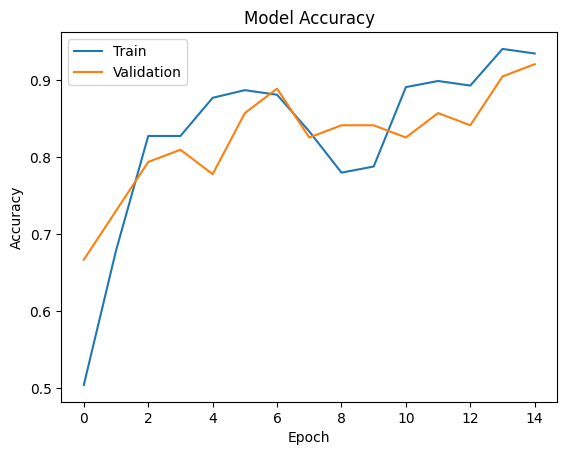

In [41]:
plt.plot(history_1.history['recall'])
plt.plot(history_1.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
model_1_train_perf = model_performance_classification(model_1, X_train_rgb,y_train_cat)

print("Train performance metrics")
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.944444  0.944444   0.947326  0.944392


In [43]:
model_1_valid_perf = model_performance_classification(model_1, X_val_rgb,y_val_cat)

print("Validation performance metrics")
print(model_1_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.920635  0.920635    0.92102  0.920595


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


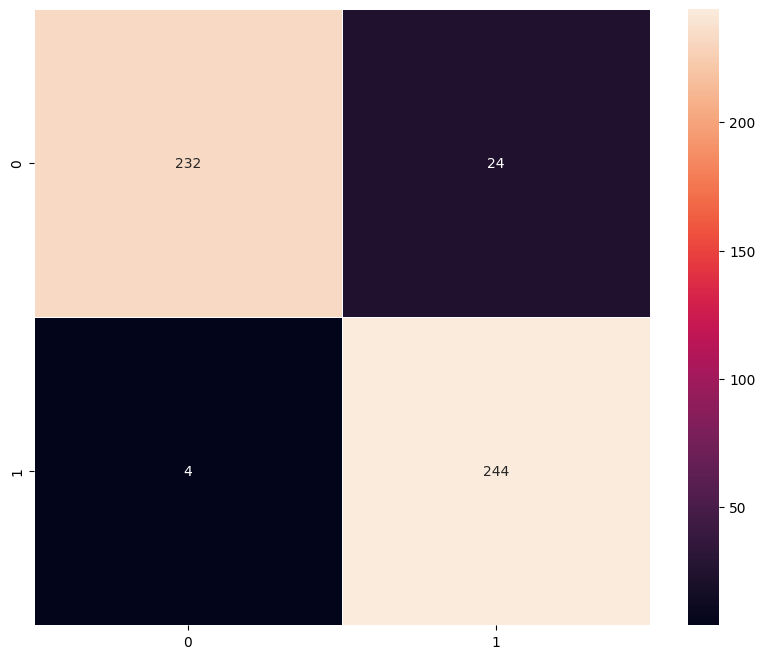

In [44]:
plot_confusion_matrix(model_1,X_train_rgb,y_train_cat)

### ANN with edge Images

In [45]:
from tensorflow.keras.utils import to_categorical
num_classes = labels['Label'].nunique()

y_train_cato = to_categorical(y_train_edge, num_classes)
y_val_cato   = to_categorical(y_val_edge, num_classes)

In [46]:

X_train_edge = np.expand_dims(X_train_edge,axis=-1)
image_size = X_train_edge[0].size
shape = X_train_edge.shape[1:]

In [47]:
model_2 = Sequential()
model_2.add(Input(shape=(shape[0],shape[1],shape[2])))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu',kernel_initializer='he_uniform',input_shape=(image_size,)))
model_2.add(Dense(20, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dense(10, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dense(5, activation='relu',kernel_initializer='he_uniform'))

model_2.add(Dense(num_classes, activation='softmax'))

In [48]:
adam = optimizers.Adam()
model_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['recall'])

In [49]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │     2,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,347 (7.63 MB)

 Trainable params: 2,001,347 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
train_datagen = ImageDataGenerator()

In [51]:
history_2 = model_2.fit(train_datagen.flow(X_train_edge,y_train_cato,batch_size=128),validation_data = (X_val_edge,y_val_cato),epochs=10, verbose=2)

Epoch 1/10
4/4 - 2s - 613ms/step - loss: 0.7879 - recall: 0.5060 - val_loss: 0.7781 - val_recall: 0.4921
Epoch 2/10
4/4 - 1s - 224ms/step - loss: 0.8980 - recall: 0.4980 - val_loss: 0.7763 - val_recall: 0.4286
Epoch 3/10
4/4 - 0s - 93ms/step - loss: 0.8282 - recall: 0.4921 - val_loss: 0.7677 - val_recall: 0.4762
Epoch 4/10
4/4 - 1s - 146ms/step - loss: 0.7710 - recall: 0.5278 - val_loss: 0.7597 - val_recall: 0.4921
Epoch 5/10
4/4 - 1s - 164ms/step - loss: 0.7258 - recall: 0.5556 - val_loss: 0.7494 - val_recall: 0.5238
Epoch 6/10
4/4 - 1s - 135ms/step - loss: 0.6792 - recall: 0.6052 - val_loss: 0.7405 - val_recall: 0.5238
Epoch 7/10
4/4 - 1s - 166ms/step - loss: 0.6293 - recall: 0.6726 - val_loss: 0.7351 - val_recall: 0.5238
Epoch 8/10
4/4 - 1s - 150ms/step - loss: 0.5891 - recall: 0.7103 - val_loss: 0.7363 - val_recall: 0.5238
Epoch 9/10
4/4 - 1s - 144ms/step - loss: 0.5475 - recall: 0.7599 - val_loss: 0.7445 - val_recall: 0.5079
Epoch 10/10
4/4 - 1s - 152ms/step - loss: 0.5157 - recal

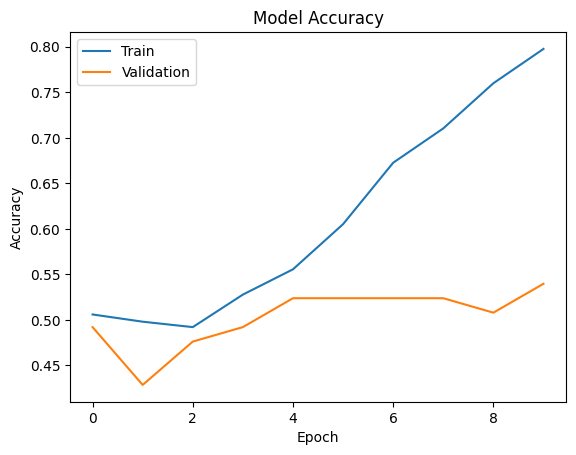

In [52]:
plt.plot(history_2.history['recall'])
plt.plot(history_2.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [53]:
model_2_train_perf = model_performance_classification(model_2, X_train_edge,y_train_cato)
print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Train performance metrics
   Accuracy   Recall  Precision  F1 Score
0   0.85119  0.85119   0.884909  0.847442


In [54]:
X_val_edge = np.expand_dims(X_val_edge, axis=-1)


In [55]:
model_2_valid_perf = model_performance_classification(model_2, X_val_edge,y_val_cato)
print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.539683  0.539683   0.758522  0.409192


### ANN with Grayscale






In [56]:
# from tensorflow.keras.utils import to_categorical
y_train_catog = to_categorical(y_train_gray, num_classes)
y_val_catog   = to_categorical(y_val_gray, num_classes)

In [57]:
# num_classes = labels['Label'].nunique()
X_train_gray = np.expand_dims(X_train_gray,axis=-1)
# image_size = X_train_gray[0].size
# shape = X_train_gray.shape[1:]

In [58]:
if len(X_train_gray.shape) == 4:   # RGB (batch, h, w, c)
    shape = X_train_gray.shape[1:]
elif len(X_train_gray.shape) == 3: # Grayscale (batch, h, w)
    shape = (X_train_gray.shape[1], X_train_gray.shape[2], 1)

In [59]:
model_3 = Sequential()
model_3.add(Input(shape=shape))
model_3.add(Flatten())
model_3.add(Dense(50, activation='relu',kernel_initializer='he_uniform',input_shape=(image_size,)))
model_3.add(Dense(20, activation='relu',kernel_initializer='he_uniform'))
model_3.add(Dense(10, activation='relu',kernel_initializer='he_uniform'))
model_3.add(Dense(5, activation='relu',kernel_initializer='he_uniform'))

model_3.add(Dense(num_classes, activation='softmax'))

In [60]:
adam = optimizers.Adam()
model_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['recall'])

In [61]:
train_datagen = ImageDataGenerator()

In [62]:
history_3 = model_3.fit(train_datagen.flow(X_train_gray,y_train_catog,batch_size=128),validation_data = (X_val_gray,y_val_catog),epochs=15, verbose=2)

Epoch 1/15
4/4 - 2s - 597ms/step - loss: 4.6400 - recall: 0.5278 - val_loss: 4.9807 - val_recall: 0.5079
Epoch 2/15
4/4 - 1s - 232ms/step - loss: 3.0560 - recall: 0.5794 - val_loss: 1.3485 - val_recall: 0.5079
Epoch 3/15
4/4 - 0s - 85ms/step - loss: 1.0133 - recall: 0.6032 - val_loss: 0.7093 - val_recall: 0.6825
Epoch 4/15
4/4 - 0s - 87ms/step - loss: 0.6798 - recall: 0.7321 - val_loss: 0.6871 - val_recall: 0.6825
Epoch 5/15
4/4 - 1s - 160ms/step - loss: 0.6875 - recall: 0.7698 - val_loss: 0.5900 - val_recall: 0.8254
Epoch 6/15
4/4 - 1s - 148ms/step - loss: 0.5734 - recall: 0.7798 - val_loss: 0.5167 - val_recall: 0.8095
Epoch 7/15
4/4 - 1s - 149ms/step - loss: 0.5398 - recall: 0.7976 - val_loss: 0.5167 - val_recall: 0.8730
Epoch 8/15
4/4 - 0s - 80ms/step - loss: 0.5314 - recall: 0.8135 - val_loss: 0.5017 - val_recall: 0.7778
Epoch 9/15
4/4 - 1s - 159ms/step - loss: 0.5270 - recall: 0.7639 - val_loss: 0.5030 - val_recall: 0.8571
Epoch 10/15
4/4 - 0s - 87ms/step - loss: 0.5228 - recall: 

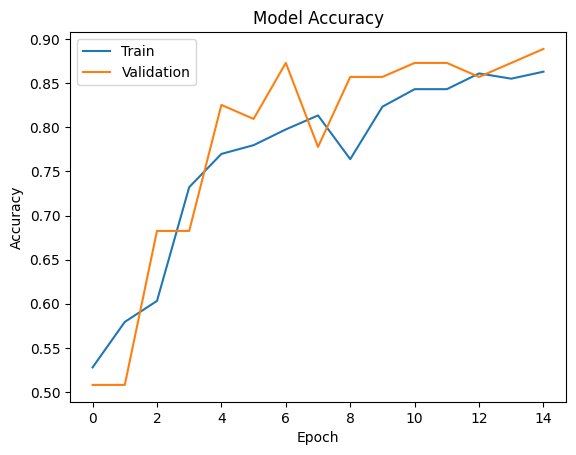

In [63]:
plt.plot(history_3.history['recall'])
plt.plot(history_3.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [64]:
model_3_train_perf = model_performance_classification(model_3, X_train_gray,y_train_catog)
print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.871032  0.871032   0.871109  0.871039


In [65]:
X_val_gray= np.expand_dims(X_val_gray, axis=-1)


In [66]:
model_3_valid_perf = model_performance_classification(model_3, X_val_gray,y_val_catog)
print("Train performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.888889  0.888889   0.889226  0.888833


### **Defining a Convolutional Neural Network (CNN) Model**


In [67]:
X_train_gray, X_temp_gray, y_train_gray, y_temp_gray = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=42,stratify=labels)
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(X_temp_gray,y_temp_gray , test_size=0.5, random_state=42,stratify=y_temp_gray)

In [68]:
X_train_gray = X_train_gray.astype('float32')/255.0
X_val_gray = X_val_gray.astype('float32')/255.0
X_test_gray = X_test_gray.astype('float32')/255.0

In [69]:
y_train_encoded = tf.keras.utils.to_categorical(y_train_gray)
y_val_encoded = tf.keras.utils.to_categorical(y_val_gray)
y_test_encoded=tf.keras.utils.to_categorical(y_val_gray)

In [70]:
print(y_train_encoded.shape)
print(X_train_gray.shape)

(504, 2)
(504, 128, 128, 3)


In [71]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
model_4 = Sequential()

# Convolutional layers with increasing filters
model_4.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128,128, 3)))
model_4.add(MaxPooling2D((2, 2), padding='same'))
model_4.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_4.add(MaxPooling2D((4, 4), padding='same'))
model_4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_4.add(Dropout(0.5))

# Flatten and Dense layers
model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.3))

model_4.add(Dense(2, activation='softmax'))

# Compile with Adam Optimizer
opt = Adam(learning_rate=0.001)
model_4.compile(optimizer=opt, loss='binary_crossentropy', metrics=["recall"])

# Summary
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,338 (2.37 MB)

 Trainable params: 622,338 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history_4 = model_4.fit(
            X_train_gray, y_train_encoded,
            epochs=15,
            validation_data=(X_val_gray, y_val_encoded),
            shuffle=True,
            batch_size=128,
            verbose=2
)

Epoch 1/15
4/4 - 52s - 13s/step - loss: 0.6913 - recall: 0.5437 - val_loss: 0.6218 - val_recall: 0.5238
Epoch 2/15
4/4 - 85s - 21s/step - loss: 0.5589 - recall: 0.7083 - val_loss: 0.4304 - val_recall: 0.7460
Epoch 3/15
4/4 - 79s - 20s/step - loss: 0.3592 - recall: 0.8770 - val_loss: 0.2705 - val_recall: 0.8889
Epoch 4/15
4/4 - 82s - 21s/step - loss: 0.2420 - recall: 0.9246 - val_loss: 0.0679 - val_recall: 1.0000
Epoch 5/15
4/4 - 60s - 15s/step - loss: 0.1739 - recall: 0.9425 - val_loss: 0.1997 - val_recall: 0.9206
Epoch 6/15
4/4 - 49s - 12s/step - loss: 0.1699 - recall: 0.9484 - val_loss: 0.0791 - val_recall: 0.9841
Epoch 7/15
4/4 - 50s - 12s/step - loss: 0.1037 - recall: 0.9841 - val_loss: 0.0881 - val_recall: 0.9841
Epoch 8/15
4/4 - 83s - 21s/step - loss: 0.0710 - recall: 0.9841 - val_loss: 0.0152 - val_recall: 1.0000
Epoch 9/15
4/4 - 49s - 12s/step - loss: 0.0701 - recall: 0.9861 - val_loss: 0.0822 - val_recall: 0.9841
Epoch 10/15
4/4 - 81s - 20s/step - loss: 0.0809 - recall: 0.9901

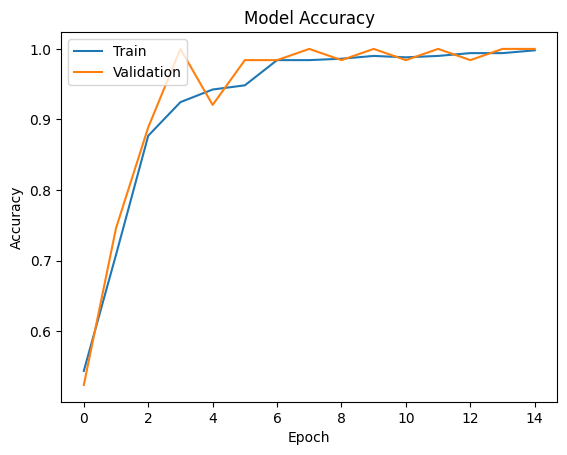

In [74]:
plt.plot(history_4.history['recall'])
plt.plot(history_4.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [75]:
model_4_train_perf = model_performance_classification(model_4, X_train_gray,y_train_cat)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 883ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.998016  0.998016   0.998024  0.998016


In [76]:
model_4_valid_perf = model_performance_classification(model_4, X_val_gray,y_val_cat)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


### Model 2: (VGG-16 (Base + FFNN))



In [77]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [78]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
for layer in vgg_model.layers:
    layer.trainable = False

In [80]:
model_5 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_5.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_5.add(Flatten())

#Adding the Feed Forward neural network
model_5.add(Dense(32,activation='relu'))
model_5.add(Dropout(rate=0.5))
model_5.add(Dense(16,activation='relu'))
model_5.add(Dropout(rate=0.3))
model_5.add(Dense(8, activation='relu'))

# Adding a dense output layer
model_5.add(Dense(2, activation='softmax'))

In [81]:
opt = Adam(learning_rate = 0.0001)

In [82]:
# Compile model
model_5.compile(optimizer=opt,loss='binary_crossentropy', metrics=["recall"])

In [83]:
model_5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,226 (58.38 MB)

 Trainable params: 590,538 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [84]:
train_datagen = ImageDataGenerator()

In [85]:
# Epochs
epochs = 10
# Batch size
batch_size = 32

history_5 = model_5.fit(train_datagen.flow(X_train_rgb,y_train_cat,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=True),
                    epochs=epochs,
                    steps_per_epoch=X_train_rgb.shape[0] // batch_size,
                    validation_data=(X_val_rgb,y_val_cat),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 312s 21s/step - loss: 0.6669 - recall: 0.5819 - val_loss: 0.5329 - val_recall: 0.9365
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 0.5918 - recall: 0.6875 - val_loss: 0.5228 - val_recall: 0.9365
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 319s 21s/step - loss: 0.4894 - recall: 0.8618 - val_loss: 0.2917 - val_recall: 1.0000
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - loss: 0.3594 - recall: 0.9062 - val_loss: 0.2796 - val_recall: 1.0000
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 312s 21s/step - loss: 0.3674 - recall: 0.8664 - val_loss: 0.2490 - val_recall: 1.0000
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.2753 - recall: 0.9375 - val_loss: 0.2476 - val_recall: 1.0000
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 314s 21s/step - loss: 0.3269 - recall: 0.8820 - val_loss: 0.2016 - val_recall: 1.0000
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.3039 - recall: 0.9688 - val_loss: 0.2005 - val_recall: 1.0000
Epoch 9/10
15/15

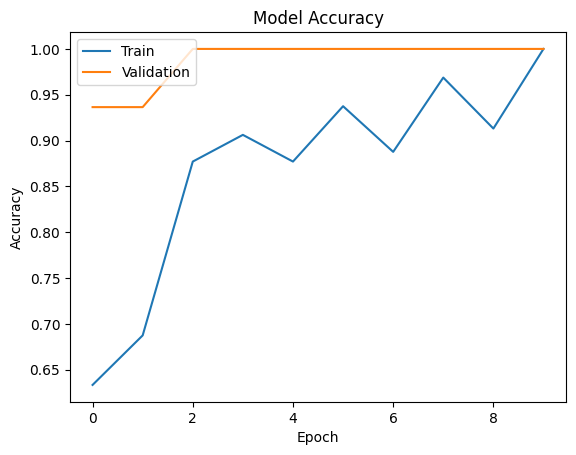

In [86]:
plt.plot(history_5.history['recall'])
plt.plot(history_5.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [87]:
model_5_train_perf = model_performance_classification(model_5, X_train_rgb,y_train_encoded)

print("Train performance metrics")
print(model_5_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 291s 18s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


In [88]:
model_5_valid_perf = model_performance_classification(model_5, X_val_rgb,y_val_encoded)

print("Validation performance metrics")
print(model_5_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 17s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


## Model 3: (VGG-16 (Base + FFNN + Data Augmentation)

In [89]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model_6 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_6.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_6.add(Flatten())

#Adding the Feed Forward neural network
model_6.add(Dense(32,activation='relu'))
model_6.add(Dropout(rate=0.5))
model_6.add(Dense(16,activation='relu'))
model_6.add(Dropout(rate=0.3))
model_6.add(Dense(8, activation = 'relu'))

# Adding a dense output layer
model_6.add(Dense(2, activation='softmax'))

In [91]:
opt=Adam(learning_rate = 0.0001)
# Compile model
model_6.compile(optimizer=opt, loss="binary_crossentropy", metrics=["recall"])

In [92]:
model_6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,226 (58.38 MB)

 Trainable params: 590,538 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [93]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.3,height_shift_range=0.3,shear_range=0.3,zoom_range=0.4
                              )

In [94]:
# Epochs
epochs = 10
# Batch size
batch_size = 32

history_6= model_6.fit(train_datagen.flow(X_train_rgb,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_rgb.shape[0] // batch_size,
                    validation_data=(X_val_rgb,y_val_encoded),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 361s 24s/step - loss: 0.6870 - recall: 0.5783 - val_loss: 0.6043 - val_recall: 0.7937
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.6637 - recall: 0.6250 - val_loss: 0.6001 - val_recall: 0.8095
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 336s 21s/step - loss: 0.6121 - recall: 0.6775 - val_loss: 0.5414 - val_recall: 0.9841
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.5635 - recall: 0.8750 - val_loss: 0.5382 - val_recall: 0.9841
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 323s 21s/step - loss: 0.5548 - recall: 0.8009 - val_loss: 0.4505 - val_recall: 1.0000
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.5563 - recall: 0.8750 - val_loss: 0.4464 - val_recall: 1.0000
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 310s 21s/step - loss: 0.4960 - recall: 0.8452 - val_loss: 0.4137 - val_recall: 1.0000
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.4323 - recall: 0.8438 - val_loss: 0.4110 - val_recall: 1.0000
Epoch 9/10
15/15

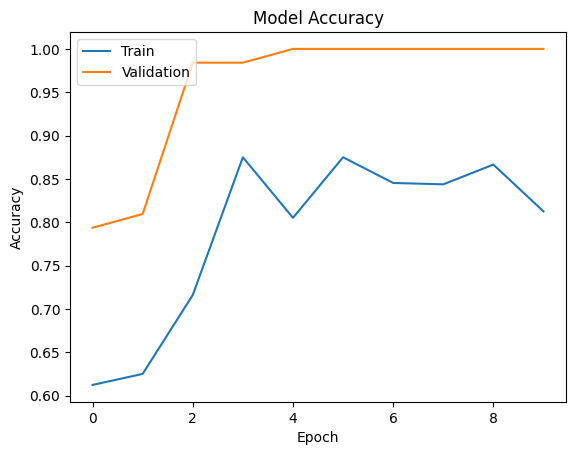

In [95]:
plt.plot(history_6.history['recall'])
plt.plot(history_6.history['val_recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [96]:
model_6_train_perf = model_performance_classification(model_6, X_train_rgb,y_train_encoded)

print("Train performance metrics")
print(model_6_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 289s 18s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


In [97]:
model_6_valid_perf = model_performance_classification(model_6, X_val_rgb,y_val_encoded)

print("Validation performance metrics")
print(model_6_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 17s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


# **Model Performance Comparison and Final Model Selection**

In [108]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        # model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T,
        model_6_train_perf.T

        # "Simple ANN with preprocessed images and Image Flattening-edge"
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple ANN with Image Flattening","Simple ANN with preprocessed images and Image Flattening-GrayScale","Simple Convolutional Neural Network (CNN)-GrayScale", "VGG-16 (Base+FFNN)", "VGG-16 (Base+FFNN+Data Aug)"
]

In [109]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        # model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T,
        model_5_valid_perf.T,
        model_6_valid_perf.T



    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Simple ANN with Image Flattening","Simple ANN with preprocessed images and Image Flattening-GrayScale","Simple Convolutional Neural Network (CNN)-GrayScale", "VGG-16 (Base+FFNN)", "VGG-16 (Base+FFNN+Data Aug)"
]

In [110]:
models_train_comp_df

,Simple ANN with Image Flattening,Simple ANN with preprocessed images and Image Flattening-GrayScale,Simple Convolutional Neural Network (CNN)-GrayScale,VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.944444,0.871032,0.998016,1.0,1.0
Recall,0.944444,0.871032,0.998016,1.0,1.0
Precision,0.947326,0.871109,0.998024,1.0,1.0
F1 Score,0.944392,0.871039,0.998016,1.0,1.0


In [112]:
models_valid_comp_df

,Simple ANN with Image Flattening,Simple ANN with preprocessed images and Image Flattening-GrayScale,Simple Convolutional Neural Network (CNN)-GrayScale,VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.920635,0.888889,1.0,1.0,1.0
Recall,0.920635,0.888889,1.0,1.0,1.0
Precision,0.921020,0.889226,1.0,1.0,1.0
F1 Score,0.920595,0.888833,1.0,1.0,1.0


In [102]:
# === Select Best Model Based on Validation F1 Score ===
# We'll use F1-score as selection criterion
val_recall_scores = models_valid_comp_df.loc["Recall"]

# Get the index of best model
best_model_idx = val_recall_scores.values.argmax()
best_model_name = val_recall_scores.index[best_model_idx]
best_recall_score = val_recall_scores.values[best_model_idx]

print(f"\nBest Model Based on Validation Recall Score: {best_model_name} (recall = {best_recall_score:.4f})")



Best Model Based on Validation Recall Score: Simple Convolutional Neural Network (CNN)-GrayScale (recall = 1.0000)


### Test Performance

In [103]:
y_test_catog = to_categorical(y_test_rgb, num_classes)

In [113]:
model_6_test_perf = model_performance_classification(model_6,
                                                     X_test_rgb,
                                                     y_test_catog)

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 19s/step


In [114]:
model_6_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 18s/step


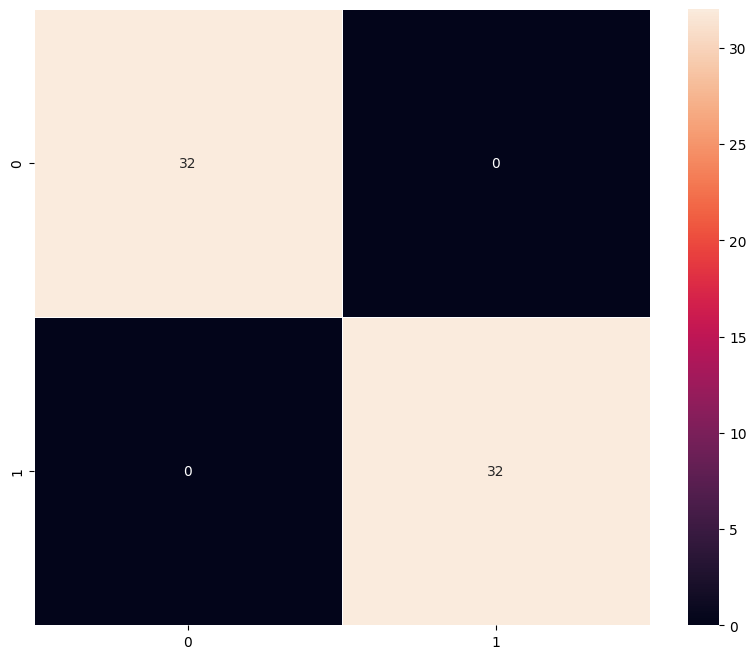

In [116]:
plot_confusion_matrix(model_6, X_test_rgb,y_test_catog)